In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from tqdm import tqdm

folder = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/benchmarks/benchmark_data"
files = glob.glob(folder + "/*.pkl")
figure_folder = "../benchmarks/figures/"

# Analysis of benchmark results 
3 models were compared on CPU: 
- standard torch model 
- torch model with `torch.compile`
- ONNX optimized model, equivalent to torch model

In [2]:
trials = []
for file in tqdm(files):
    with open(file, "rb") as f:
        data = pickle.load(f)
        # Create a list of dictionaries, where each dictionary represents a single trial
    params = data['params']
    model_load_time = data['model_load_time']

    for i, (batch_time, ram) in enumerate(zip(data['batch_times'],
                                              data['batch_ram_usages'])):

        trial = {**params, 'batch_time': batch_time, 'trial': i, 'ram': ram,
                'model_loading_time': model_load_time}
        trials.append(trial)


100%|██████████| 22/22 [00:00<00:00, 621.58it/s]


In [3]:
# Create a Pandas DataFrame from the list of dictionaries
df_full = pd.DataFrame(trials)
df = df_full

In [21]:
# convert backend and compile to single column
df['backend_full'] = df['backend'].str.cat(df['compile'].replace(1, 'compiled').replace(0, ''), sep=' ')

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

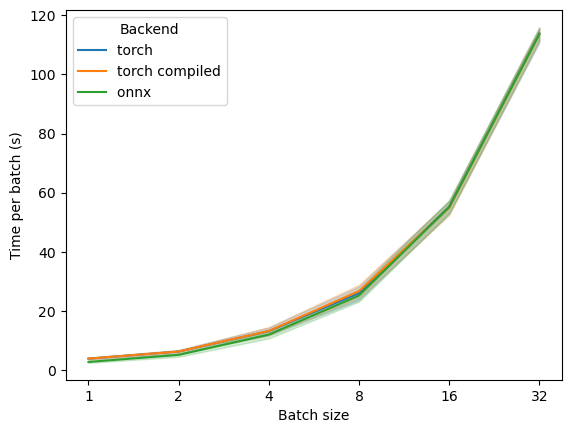

In [11]:
single_thread = df.query("threads == 1")

sns.lineplot(x='batch_size', y='batch_time', hue='backend_full', data=single_thread)
# convert x axis to only logs of 2
plt.xscale('log', base=2)
# change x axis labels to be more readable
plt.xticks([2**i for i in range(0, 6)], [2**i for i in range(0, 6)])
plt.xlabel('Batch size')
plt.ylabel('Time per batch (s)')
# change legend title
plt.legend(title='Backend');

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


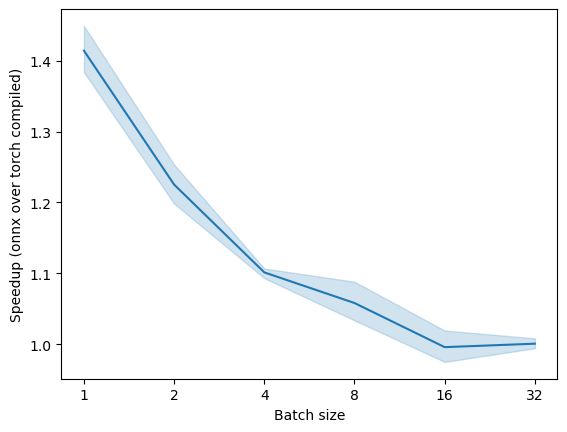

In [24]:
# calculate speedup of onnx vs torch among the same trials
onnx = df.query("backend == 'onnx' and threads == 1")
torch = df.query("backend == 'torch' and compile == 1")
onnx = onnx.rename(columns={'batch_time': 'onnx_batch_time'})
torch = torch.rename(columns={'batch_time': 'torch_batch_time'})
onnx = onnx[['batch_size', 'onnx_batch_time', 'trial']]
torch = torch[['batch_size', 'torch_batch_time', 'trial']]
merged = onnx.merge(torch, on=['batch_size', 'trial'])
merged['speedup'] = merged['torch_batch_time'] / merged['onnx_batch_time']
sns.lineplot(x='batch_size', y='speedup', data=merged)

# convert x axis to only logs of 2
plt.xscale('log', base=2)
# change x axis labels to be more readable
plt.xticks([2**i for i in range(0, 6)], [2**i for i in range(0, 6)])
plt.xlabel('Batch size')
plt.ylabel('Speedup (onnx over torch compiled)');

/tmp/ipykernel_3533413/528590422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onnx_thread['speedup'] = onnx_thread['batch_time'] / onnx_thread.query("threads == 1")['batch_time'].mean()
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remove

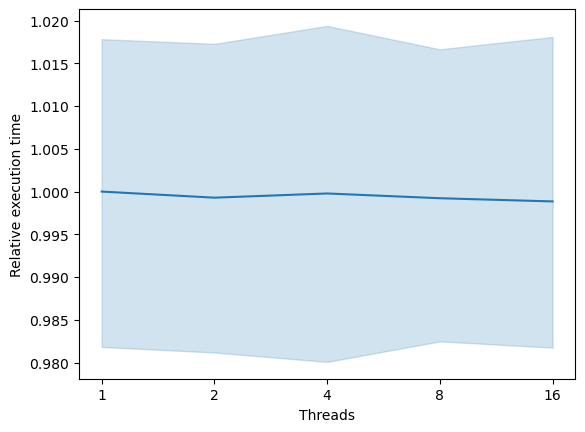

In [14]:
onnx_thread = df_full.query("batch_size == 32 & backend == 'onnx'");
# calculate relative speedup to single thread
onnx_thread['speedup'] = onnx_thread['batch_time'] / onnx_thread.query("threads == 1")['batch_time'].mean()
# plot onnx speedup vs threads
sns.lineplot(x='threads', y='speedup', data=onnx_thread)
plt.xlabel('Threads')
plt.ylabel('Relative execution time');
# log scale x axis
plt.xscale('log', base=2)
plt.xticks([2**i for i in range(0, 5)], [2**i for i in range(0, 5)]);

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option

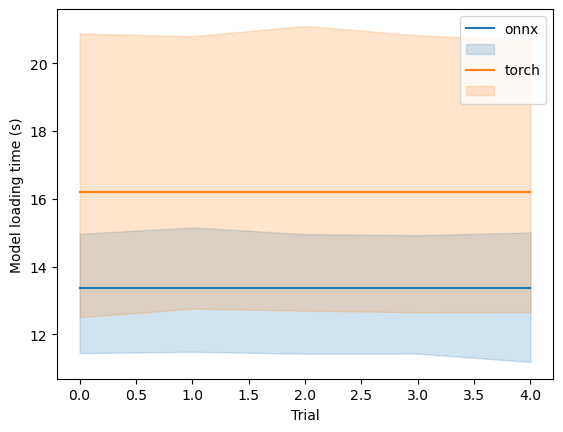

In [20]:
# plot model loading time in three figures
# onnx vs torch
# by trial
# select only unique trials
onnx = df.query("backend == 'onnx'")
# select one loading time per trial
torch = df.query("backend == 'torch'")

sns.lineplot(x='trial', y='model_loading_time', data=onnx,
            legend=False)
sns.lineplot(x='trial', y='model_loading_time', data=torch)
plt.xlabel('Trial');
plt.ylabel('Model loading time (s)')
plt.legend(['onnx', "", "torch", ""]);

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inste

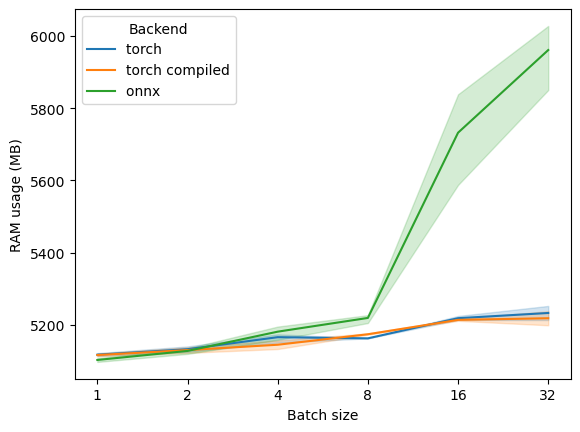

In [19]:
# plot ram usage with batch sizes
sns.lineplot(x='batch_size', y='ram', hue='backend_full', data=single_thread)

# convert x axis to only logs of 2
plt.xscale('log', base=2)
# change x axis labels to be more readable
plt.xticks([2**i for i in range(0, 6)], [2**i for i in range(0, 6)])
plt.xlabel('Batch size')
plt.ylabel('RAM usage (MB)')
# change legend title
plt.legend(title='Backend');

# Conclusions 
## Compatibility of outputs 
- Non-quantized model outputs identical embeddings, quantized model is not comparable to the non-quantized model. 
## Speed
- ONNX is more 1-1.4x performant than torch, noticeably on smaller batches. 
## RAM 
- Quantized ONNX model consumes way less RAM.
## Model loading 
- ONNX model is loaded a bit faster.
## Threading 
- Adding more threads did not influence execution time in ONNX. 
